# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


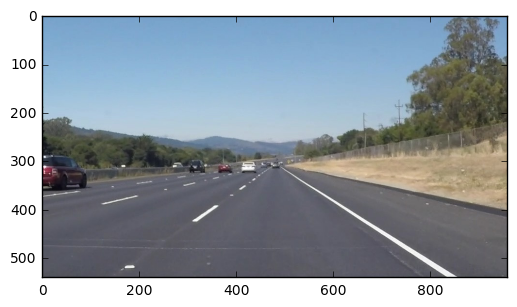

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_img = np.zeros(img.shape, dtype=np.uint8)
    # make sure we convert back to color before we draw the line
    line_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)
    
    if lines is None:
        return line_img

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_average_lines(image, lines, α, prev):

    # slopes are used to separate lines into right and left side
    slopes = []
    top = 0
    bottom = image.shape[0]

    if lines is not None: 
        slopes = np.apply_along_axis(get_slope, 2, lines)
        # top and bottom point same for both lines
        top = np.min(lines.reshape(-1,2)[:,1])
    else:
        top = prev.get('top', top)

    # sort into sides and average
    avgs = []

    for name, lower, upper in [('left', -0.8, -0.5), ('right', 0.5, 0.8)]:
        # Separate points into left or right side
        side_lines = []
        if len(slopes):
            side_lines = lines[np.logical_and(slopes >= lower, slopes < upper)]
        # If current side does not have any lines, use previous values
        if len(side_lines) == 0:
            slope, intercept = [prev.get('slope_' + name), prev.get('intercept_' + name)]
        # Average out all lines on current side
        else:
            # reshape lines into x, y series for polyfit
            side_lines = side_lines.reshape(-1,2)
            x = side_lines[:,0]
            y = side_lines[:,1]
            slope, intercept = np.polyfit(x, y, 1)
            # smoothing
            slope = prev.get('slope_' + name, slope) * (1. - α) + α * slope
            intercept = prev.get('intercept_' + name, intercept) * (1. - α) + α * intercept   
            # update prev
            prev['slope_' + name] = slope
            prev['intercept_' + name] = intercept

        # Smoothing
        top = prev.get('top', top) * (1. - α) + α * top
        bottom = prev.get('bottom', bottom) * (1. - α) + α * bottom
        # Update prev
        prev['top'] = top
        prev['bottom'] = bottom

        # Averaged line points
        avg = np.array([
            (bottom - intercept) / slope, bottom, 
            (top - intercept) / slope, top
        ]).astype(int)        
        avgs.append([avg])

    return avgs, prev

def get_slope(line):
    x1,y1,x2,y2 = line
    slope = ((y2-y1)/(x2-x1))
    return slope

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

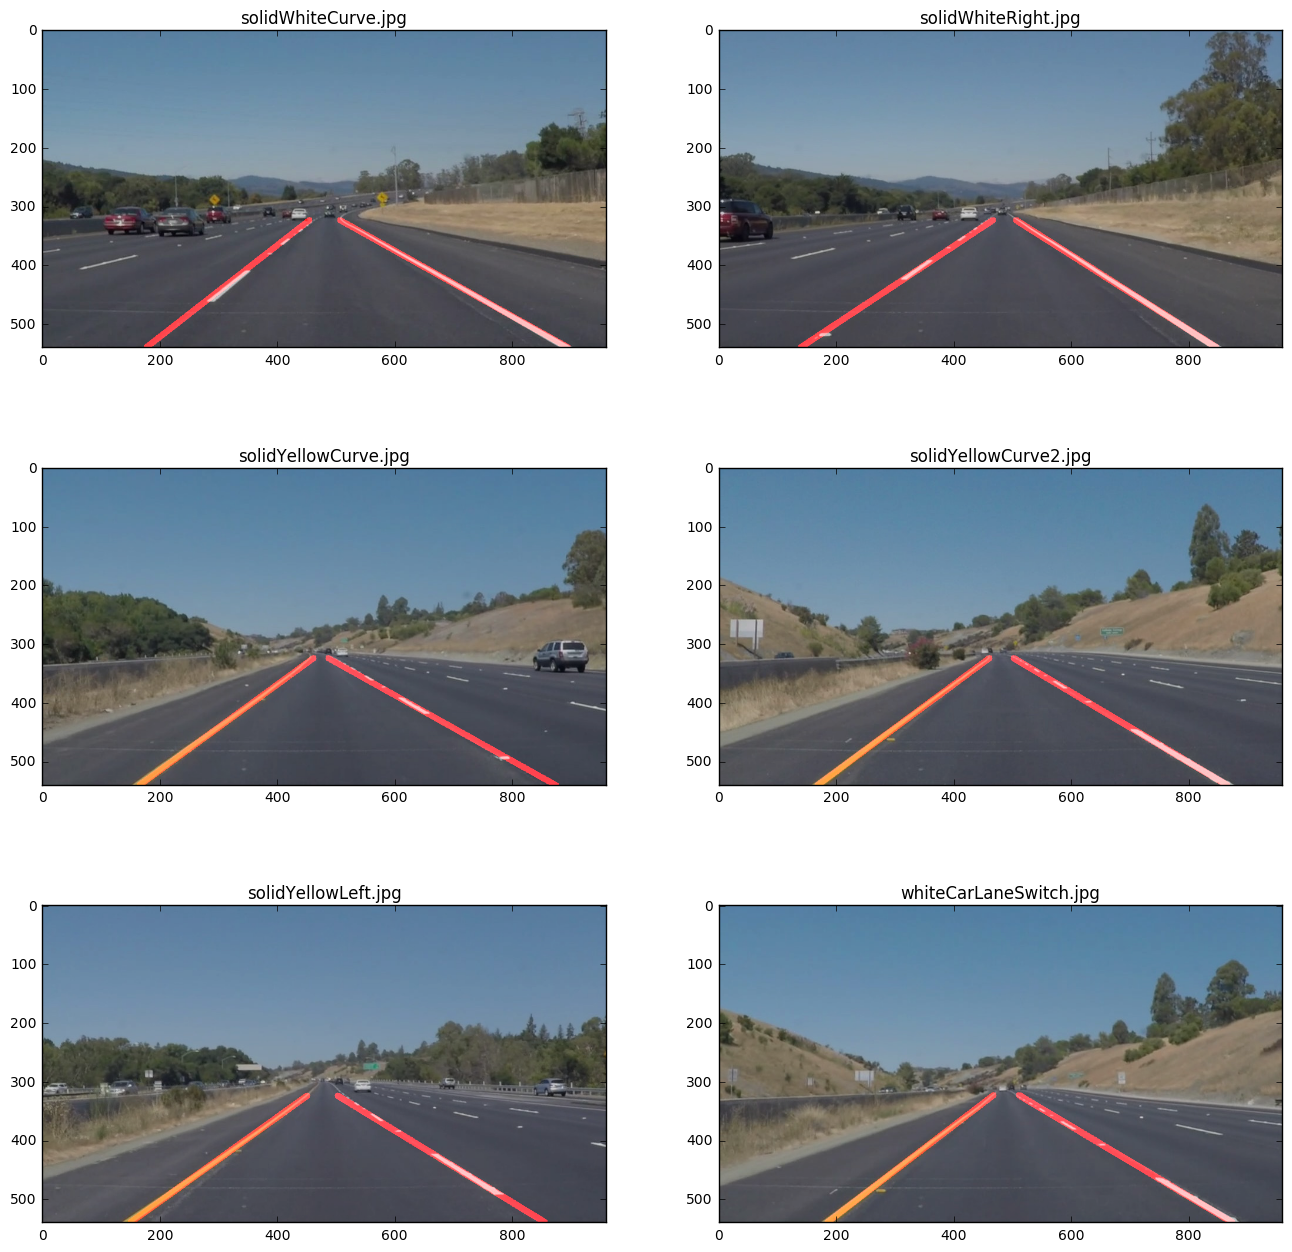

In [20]:
import os

def add_lines(image, average=False, α=1.0):
    image_ = image

    # canny edge
    image_ = grayscale(image_)
    image_ = gaussian_blur(image_, 9)
    image_ = canny(image_, 30, 150)

    # crop image to section containing lines
    height = image_.shape[0]
    width = image_.shape[1]
    vertices = np.array([
        [
            (0.05*width,image_.shape[0]),
            (width/2.16, height*.60),
            (width/1.76, height*.60),
            (0.95*width,image_.shape[0])
        ]
    ], dtype=np.int32)
    image_ = region_of_interest(image_, vertices)
    
    # hough transform
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    lines = hough_lines(image_, rho, theta, threshold, min_line_length, max_line_gap)

    # if averaging, replace exiting lines with averaged lines
    if average:
        lines, add_lines.prev = get_average_lines(image_, lines, α, add_lines.prev)

    line_img = draw_lines(image_, lines, color=[255, 0, 0], thickness=10)

    # note: drawing lines over original image
    image = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
    return image
add_lines.prev = {}

files = os.listdir("test_images/")
num_images = len(files)
plt.subplots(figsize=(16, 16))

plotidx = 0
for idx, filename in enumerate(files):
    if "processed" in filename:
        continue

    image = mpimg.imread("test_images/" + filename)
    image = add_lines(image, average=True)
    subplot = plt.subplot(3, 2, plotidx+1)
    subplot.title.set_text(filename)

    plt.imshow(image)
    plotidx += 1

plt.savefig("test_images/processed.jpg")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return add_lines(image, average=True, α=0.1)

Let's try the one with the solid white lane on the right first ...

In [13]:
add_lines.prev = {}
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 81.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.48 s, sys: 1.3 s, total: 3.78 s
Wall time: 3.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
add_lines.prev = {}
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 75.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.47 s, sys: 3.59 s, total: 12.1 s
Wall time: 9.44 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

---

There are number of opportunities to improve my lane finding pipeline.

One problem area is conditions where the gradient between the line and the road is not significant, such as in the challenge video where a small section of the road is brown with a yellow line.  In my pipeline, I have side stepped this issue by simply using the previous slope, and intercept for the drawn line.  If however, the entire road was this color we would need a more robust solution.  Decreasing the threshold for Canny edge detection might allow the edges for the yellow lane in this case to be detected.  However in doing so we increase the number spurious edges detected.  Perhaps color mask filters could either remove the brown or accentuate the yellow line before running Canny edge detection.

Poor weather, such as rain could create noisy edges.  In this case perhaps increasing the bin size parameter for hough lines might allow these edges to be detected, or maybe several frames could be merged together to get a more clear picture of a section of the road before doing edge detection.

Another small improvement could be to draw a curved line instead of a straight line.  The step that averages the line could instead fit a 2nd or third order polynomial, which might look a little nicer on curved roads.

A larger concern, is that the pipeline would break down if the car is not already centered within the lanes.  Two methods employed in my pipeline assume the car is centered within the lanes.  The region mask, as well as slope filtering would not longer make sense if we did not know where the lanes were position.  Other than color, perhaps shape of the edges would allow for a more robust solution that did not rely on orientation of the car.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
add_lines.prev = {}
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:06<00:00, 38.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.12 s, sys: 2 s, total: 7.11 s
Wall time: 7.29 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))